<a href="https://colab.research.google.com/github/GuangjingCao/GuangjingCao/blob/main/Github_Team7_Working_AJL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Condition Classification Across Diverse Skin Tones

This notebook builds a machine learning model to classify 21 skin conditions using a subset of the Fitzpatrick17k dataset. Our goal is to achieve a high weighted average F1 score on the Kaggle leaderboard by leveraging:
- **Data Augmentation**: To expand and balance the dataset across skin tones.
- **Transfer Learning**: Using EfficientNetB0, a powerful pretrained model, fine-tuned for our task.
- **Fairness**: Ensuring the model works well across diverse skin tones.

Let’s dive in!

In [ ]:
# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Import necessary libraries
import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Define file paths
folder_path = '/content/drive/MyDrive/MIT-AJL-7'
train_img_folder_path = '/content/drive/MyDrive/MIT-AJL-7/train/train'
test_img_folder_path = '/content/drive/MyDrive/MIT-AJL-7/test/test'

print("Drive mounted and libraries imported!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted and libraries imported!


## Step 1: Load and Prepare the Data

Here, we load the `train.csv` and `test.csv` files, which contain metadata about the images. We’ll:
- Add `.jpg` to the `md5hash` column to match image filenames.
- Create full file paths for training images using their labels.
- Check the data to ensure everything looks good.


In [ ]:
# Load CSV files
train_df = pd.read_csv(os.path.join(folder_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(folder_path, 'test.csv'))

# Add .jpg extension to md5hash
train_df['md5hash'] = train_df['md5hash'].astype(str) + '.jpg'
test_df['md5hash'] = test_df['md5hash'].astype(str) + '.jpg'

# Create full file paths for training images (e.g., 'acne-vulgaris/16d1e6b4143c88cb158a50ea8bc3a595.jpg')
train_df['file_path'] = train_df['label'] + '/' + train_df['md5hash']

# Display the first few rows
print("Training Data Sample:")
print(train_df[['md5hash', 'label', 'file_path']].head())
print("\nTest Data Sample:")
print(test_df[['md5hash']].head())

# Encode labels for training
label_encoder = LabelEncoder()
train_df['encoded_label'] = label_encoder.fit_transform(train_df['label'])

# Save the number of classes (should be 21)
num_classes = len(label_encoder.classes_)
print(f"Number of unique skin conditions: {num_classes}")

Training Data Sample:
                                md5hash                             label  \
0  fd06d13de341cc75ad679916c5d7e6a6.jpg                 prurigo-nodularis   
1  a4bb4e5206c4e89a303f470576fc5253.jpg  basal-cell-carcinoma-morpheiform   
2  c94ce27e389f96bda998e7c3fa5c4a2e.jpg                            keloid   
3  ebcf2b50dd943c700d4e2b586fcd4425.jpg              basal-cell-carcinoma   
4  c77d6c895f05fea73a8f3704307036c0.jpg                 prurigo-nodularis   

                                           file_path  
0  prurigo-nodularis/fd06d13de341cc75ad679916c5d7...  
1  basal-cell-carcinoma-morpheiform/a4bb4e5206c4e...  
2        keloid/c94ce27e389f96bda998e7c3fa5c4a2e.jpg  
3  basal-cell-carcinoma/ebcf2b50dd943c700d4e2b586...  
4  prurigo-nodularis/c77d6c895f05fea73a8f37043070...  

Test Data Sample:
                                md5hash
0  0844ae634f0e6e7ef1f73c2aeecbae0e.jpg
1  3b290d262098f761d719aa07cf36c040.jpg
2  cf561d08ac46d0fda678bff6621005ee.jpg
3  e63

## Step 2: Data Exploration
Below we visualize different distributions and relationships across the datasets provded by the AJL Kaggle competition.
* No additional sources were used and we will assume that all skin conditions in the provided dataset have been labeled correctly.
* Challenges faced when working with this image dataset is that we are using  real-life photos that likely contain some noise or distortion across each sample which could reduce our model accuracy.

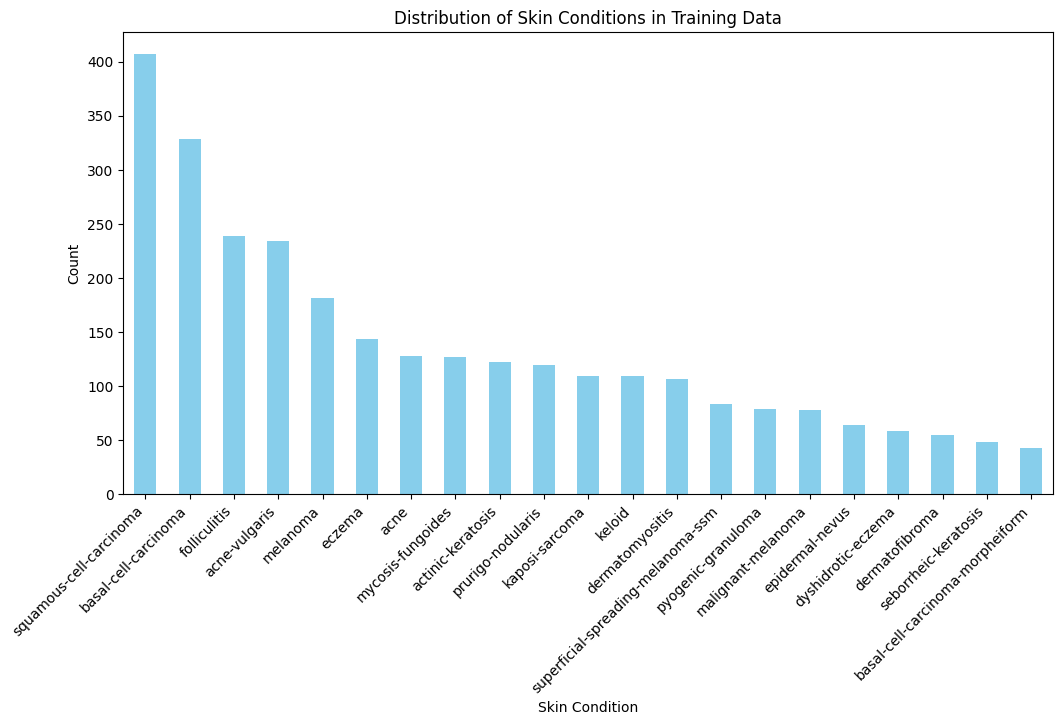

In [ ]:
# Visualize skin conditions in dataset
plt.figure(figsize=(12, 6))
train_df['label'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Distribution of Skin Conditions in Training Data")
plt.xlabel("Skin Condition")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

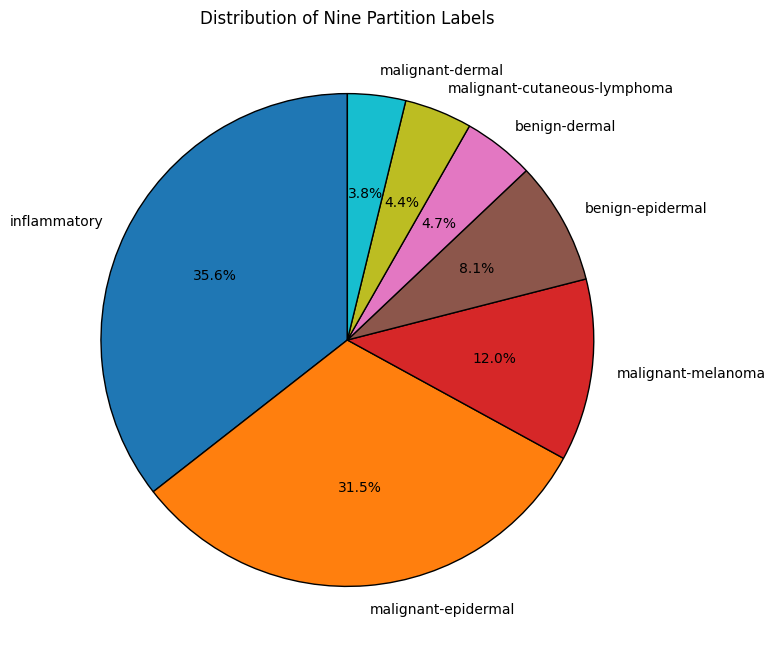

In [ ]:
# Display proportion of nine partition labels in dataset
plt.figure(figsize=(8, 8))
train_df['nine_partition_label'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', cmap='tab10', startangle=90, wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribution of Nine Partition Labels")
plt.ylabel("")  # Remove y-label
plt.show()

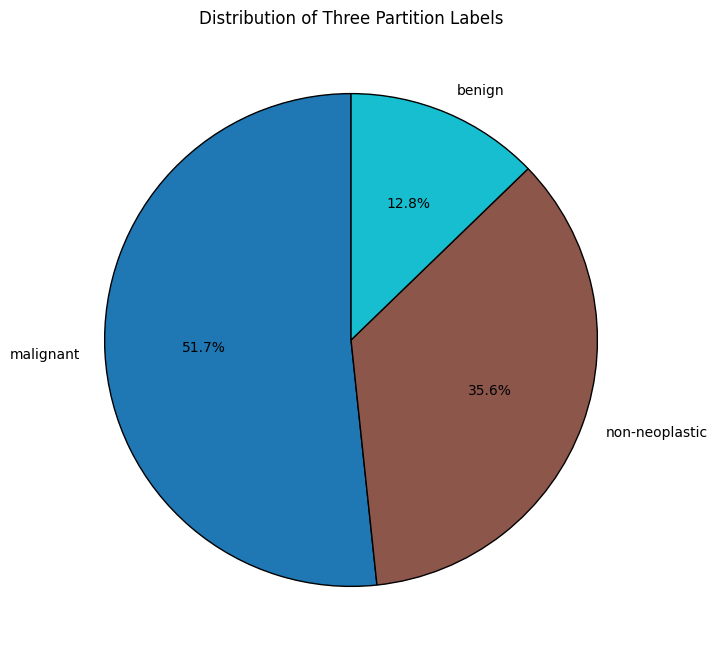

In [ ]:
# Display proportion of three partition labels in dataset
plt.figure(figsize=(8, 8))
train_df['three_partition_label'].value_counts().plot(
    kind='pie', autopct='%1.1f%%', cmap='tab10', startangle=90, wedgeprops={'edgecolor': 'black'}
)
plt.title("Distribution of Three Partition Labels")
plt.ylabel("")  # Remove y-label
plt.show()

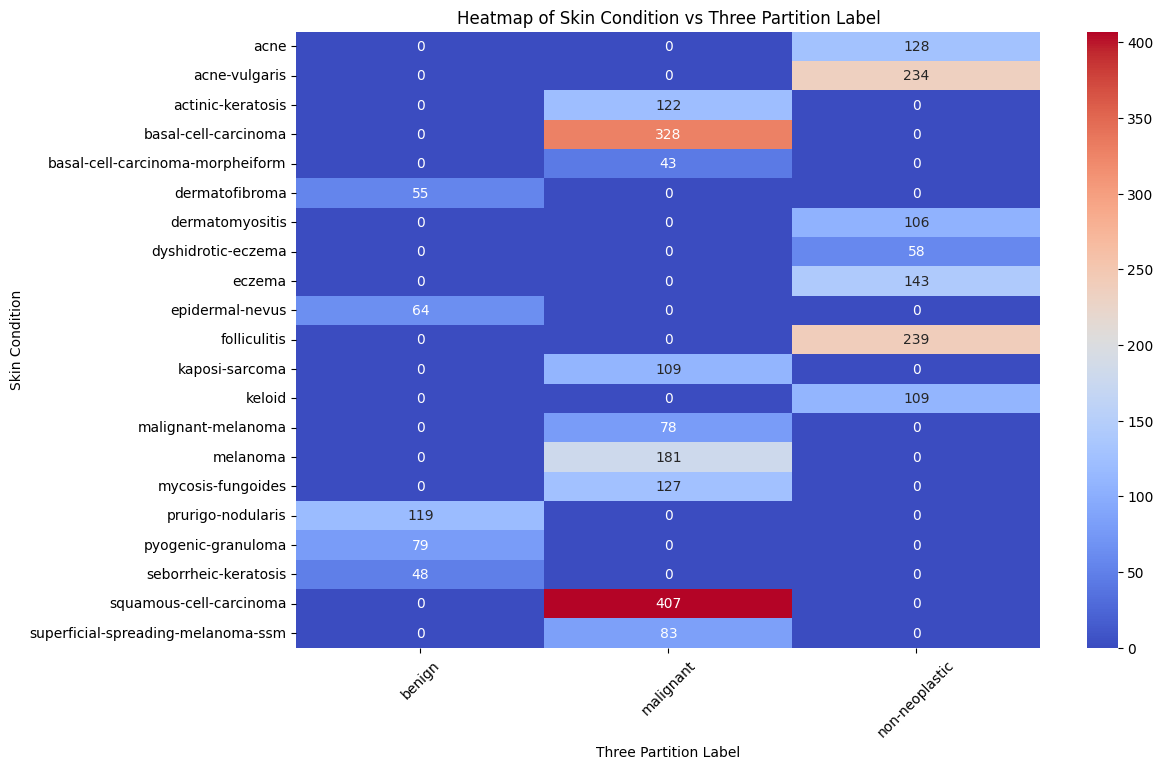

In [ ]:
# Heatmap of Skin Conditions to Three Partition Label
heatmap_data = pd.crosstab(train_df['label'], train_df['three_partition_label'])

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt="d")
plt.title("Heatmap of Skin Condition vs Three Partition Label")
plt.xlabel("Three Partition Label")
plt.ylabel("Skin Condition")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

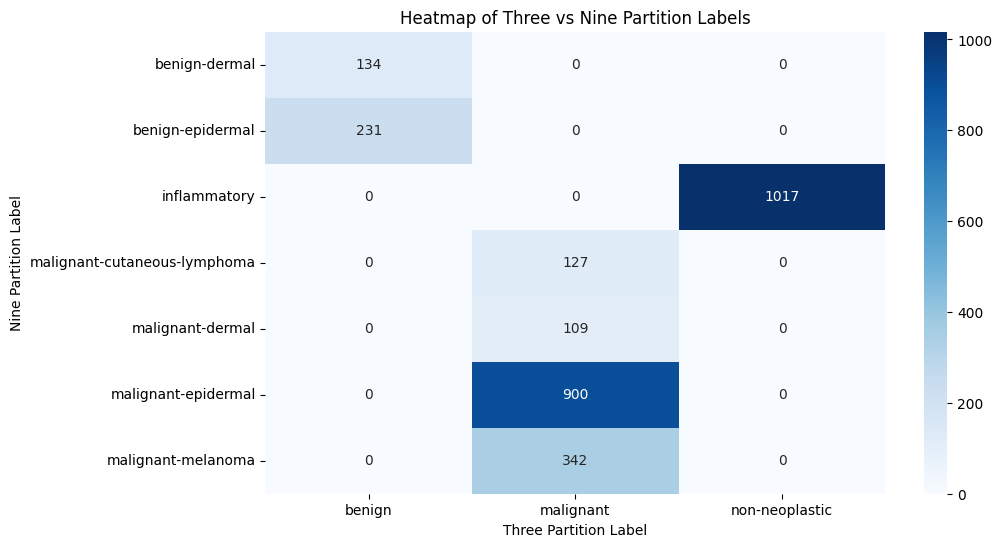

In [ ]:
#  Heatmap of Three Partition Lable to Nine Partition Label
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(train_df['nine_partition_label'], train_df['three_partition_label'])
sns.heatmap(cross_tab, annot=True, fmt='d', cmap="Blues")
plt.title("Heatmap of Three vs Nine Partition Labels")
plt.xlabel("Three Partition Label")
plt.ylabel("Nine Partition Label")
plt.show()

## Step 3: Set Up Data Augmentation and Generators

To improve our model and balance representation across skin tones, we use **data augmentation** (e.g., flipping, rotating images). We split the training data into training (80%) and validation (20%) sets, then create image generators to feed data to the model in batches.

In [ ]:
# Split data into training and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

# Define data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0, 1]
    rotation_range=20,        # Rotate images up to 20 degrees
    width_shift_range=0.2,    # Shift width by 20%
    height_shift_range=0.2,   # Shift height by 20%
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest'       # Fill empty pixels with nearest value
)

# Validation and test data only need rescaling
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Function to create generators
def create_generator(dataframe, directory, datagen, batch_size=32, target_size=(224, 224), is_train=True):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='file_path' if is_train else 'md5hash',
        y_col='encoded_label' if is_train else None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw' if is_train else None,
        shuffle=is_train,
        validate_filenames=True
    )

# Create generators
train_generator = create_generator(train_data, train_img_folder_path, train_datagen)
val_generator = create_generator(val_data, train_img_folder_path, val_datagen)
test_generator = create_generator(test_df, test_img_folder_path, test_datagen, is_train=False)

print("Data generators created successfully!")

Found 2288 validated image filenames.
Found 572 validated image filenames.
Found 1227 validated image filenames.
Data generators created successfully!


## Step 4: Build the Model with Transfer Learning

We use **EfficientNetB0**, a pretrained model, to save time and boost accuracy. We add custom layers on top for our 21-class problem and fine-tune it with our dataset.

In [ ]:
# Load pretrained EfficientNetB0 without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pretrained weights
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduce spatial dimensions
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Prevent overfitting
outputs = Dense(num_classes, activation='softmax')(x)  # Output layer for 21 classes

# Create the full model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,216,248 (16.08 MB)

 Trainable params: 166,677 (651.08 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Step 5: Train the Model

We train the model with early stopping to avoid overfitting and save the best version based on validation accuracy.

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

# Compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen base
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Fine-tune by unfreezing base model
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Even lower learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, checkpoint],
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

print("Training complete!")

NameError: name 'EarlyStopping' is not defined

## Step 6: Make Predictions and Create Submission File

We use the trained model to predict labels for the test set and format them into a submission file matching the required format: `md5hash,label`.

In [ ]:
# Make predictions on test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Convert encoded labels back to original labels
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Prepare submission dataframe
submission_df = pd.DataFrame({
    'md5hash': test_df['md5hash'].str.replace('.jpg', ''),  # Remove .jpg for submission
    'label': predicted_labels
})

# Save to CSV
submission_path = os.path.join(folder_path, 'submission.csv')
submission_df.to_csv(submission_path, index=False)

print("Submission file created at:", submission_path)
print("Sample of submission:")
print(submission_df.head())

39/39 ━━━━━━━━━━━━━━━━━━━━ 317s 8s/step
Submission file created at: /content/drive/MyDrive/MIT-AJL-7/submission.csv
Sample of submission:
                            md5hash                    label
0  0844ae634f0e6e7ef1f73c2aeecbae0e  squamous-cell-carcinoma
1  3b290d262098f761d719aa07cf36c040  squamous-cell-carcinoma
2  cf561d08ac46d0fda678bff6621005ee  squamous-cell-carcinoma
3  e6371069be05c6b0a95b4b3f1bacc9a5  squamous-cell-carcinoma
4  f76cddb37265f97508f159078dcc7e7c  squamous-cell-carcinoma
